# PyTorch教程
## 0. Import modules

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader 


## 1. Tensor Basics
### 1.1 创建Tensor
* ```torch.empty(size)```：没有初始化的tensor
* ```torch.rand(size)```：随机初始化，[0, 1]
* ```torch.zeros(size)```：全0
* ```torch.tensor(tuple or list)```：从python的dict或者tuple创建
* ```torch.from_numpy(np.array)```：从numpy的array创建

In [2]:
# torch.empty(size): uninitiallized
x = torch.empty(3, 5)
x = torch.empty_like(x)

# torch.rand(size): random numbers [0, 1]
x = torch.rand(3, 5)
x = torch.rand(x.size())
x = torch.rand_like(x)

# torch.zeros(size), fill with 0
# torch.ones(size), fill with 1
x = torch.ones(3, 5)
x = torch.ones_like(x)

# construct from python data
x = torch.tensor([1, 2, 3])

# numpy <-> cpu tensor
# If the Tensor is on the CPU (not the GPU), both objects will share the same memory location, so changing one will also change the other
a = np.ones((3, 5))
b = torch.from_numpy(a)
c = b.numpy()

# cpu <-> gpu
x_cpu = torch.rand(3, 5)
x_gpu = x_cpu.to(torch.device("cuda"))
x_gpu = torch.rand(3, 5, device=torch.device("cuda"))

# check size
# check data type
# check requires_grad
print(x.size())
print(x.dtype)
print(x.requires_grad)


torch.Size([3])
torch.int64
False


### 1.2 基本运算
* 加减除：```+, -, /, add, sub, div```
* 乘法：
  * ```*, mul```：点乘
  * ```mm, matmul```：矩阵乘法

In [3]:
x = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
y = torch.tensor([[0.1, 1], [1, 0.1]], dtype=torch.float32)

# elementwise addition, substraction, division
print(x + y)
print(torch.add(x, y))
print(x - y)
print(torch.sub(x, y))
print(x / y)
print(torch.div(x, y))

# multiplication
# elementwise
print(x * y)
print(torch.mul(x, y))
# matrix product
print(torch.mm(x, y))
print(torch.matmul(x, y))  # broadcast supported

tensor([[1.1000, 1.0000],
        [1.0000, 1.1000]])
tensor([[1.1000, 1.0000],
        [1.0000, 1.1000]])
tensor([[ 0.9000, -1.0000],
        [-1.0000,  0.9000]])
tensor([[ 0.9000, -1.0000],
        [-1.0000,  0.9000]])
tensor([[10.,  0.],
        [ 0., 10.]])
tensor([[10.,  0.],
        [ 0., 10.]])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
tensor([[0.1000, 1.0000],
        [1.0000, 0.1000]])
tensor([[0.1000, 1.0000],
        [1.0000, 0.1000]])


## 2. Autograd
* 误差还没有反向传播时，grad默认为None，第一次传播之后grad变成Tensor类的实例化对象，而且会一直累加，因此需要手动zero_
* 不需要追踪某个tensor的梯度时：
  * ```with torch.no_grad():```
  * ```x.detach_()```
  * ```x.requires_grad_(False)```

In [4]:
weights = torch.ones(3, 3, requires_grad=True)
input = torch.tensor([[0.1, 0.7], [0.2, 0.9], [0.3, 0.6]], dtype=torch.float32)
label = torch.tensor([0, 1])

epoch_loop = tqdm(range(0, 100))
for epoch in epoch_loop:
    output = torch.sigmoid(torch.matmul(weights, input).sum(dim=0))
    loss = nn.L1Loss(reduction='mean')(output, label)
    
    if weights.grad is not None:
        weights.grad.zero_()
    loss.backward()  # backward() accumulates the gradient for this tensor into .grad attribute
    with torch.no_grad():
        weights -= 0.1 * weights.grad
    
    epoch_loop.set_description("Epoch: %d" % (epoch + 1))
    epoch_loop.set_postfix_str("loss is: %.6f" % loss.item())


print(weights)
weights.requires_grad_(False)  # weights.detach_()
print(weights)
print(output.grad_fn)

Epoch: 100: 100%|██████████| 100/100 [00:00<00:00, 1430.42it/s, loss is: 0.412968]

tensor([[0.9406, 0.8760, 0.8063],
        [0.9406, 0.8760, 0.8063],
        [0.9406, 0.8760, 0.8063]], requires_grad=True)
tensor([[0.9406, 0.8760, 0.8063],
        [0.9406, 0.8760, 0.8063],
        [0.9406, 0.8760, 0.8063]])


## 3. Train Pipeline
* Design model
* Construct loss and optimizer
* Training loop:
  * forward pass: compute prediction and loss
  * backward pass: compute gradients
  * update weights

In [17]:
# numpy implementation
class NumpyImplementation(object):
    def __init__(self, w, lr, epochs=10):
        self.w = w
        self.lr = lr
        self.epochs = epochs
    
    def forward(self, x):
        return self.w * x
    
    def loss(self, y_predicted, y):
        return ((y_predicted - y) ** 2).mean()

    def grad(self, x, y_predicted, y):
        return np.dot(2 * x, (y_predicted - y)) / len(x)

    def update_weights(self, grad):
        self.w -= self.lr * grad

    def __call__(self, x):
        return self.forward(x)

    def train(self, x, y):
        print("numpy implementation".center(90, '-'))
        print(f"before training, f(5) = {self(5):.3f}")

        epoch_loop = tqdm(range(0, self.epochs))
        for epoch in epoch_loop:
            y_pred = self(x)
            l = self.loss(y_pred, y)
            g = self.grad(x, y_pred, y)
            self.update_weights(g)

            epoch_loop.set_description(f'epoch: {epoch + 1}')
            epoch_loop.set_postfix_str(f'loss = {l:.8f}, w = {self.w:.2f}')

        print(f'after training, f(5) = {self(5):.3f}')

# pytorch implementation: using autograd to obtain grad
class TorchImplementation1(NumpyImplementation):
    def __init__(self, w, lr, epochs=10):
        super(TorchImplementation1, self).__init__(w, lr, epochs)
        self.w = torch.tensor(self.w, requires_grad=True)

    def train(self, x, y):
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        print("pytorch implementation version 1".center(90, '-'))
        print(f"before training, f(5) = {self(5):.3f}")

        epoch_loop = tqdm(range(0, self.epochs))
        for epoch in epoch_loop:
            y_pred = self(x)
            l = self.loss(y_pred, y)
            if self.w.grad is not None:
                self.w.grad.zero_()
            l.backward()
            with torch.no_grad():
                self.update_weights(self.w.grad)

            epoch_loop.set_description(f'epoch: {epoch + 1}')
            epoch_loop.set_postfix_str(f'loss = {l:.8f}, w = {self.w:.2f}')

        print(f'after training, f(5) = {self(5):.3f}')

# pytorch implementation: using optimizer to update weights
class TorchImplementation2(NumpyImplementation):
    def __init__(self, w, lr, epochs=10):
        super(TorchImplementation2, self).__init__(w, lr, epochs)
        self.w = torch.tensor(self.w, requires_grad=True)
        self.optimizer = torch.optim.SGD([self.w], self.lr)  # 需要更新的权重必须是可迭代的

    def train(self, x, y):
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        print("pytorch implementation version 2".center(90, '-'))
        print(f"before training, f(5) = {self(5):.3f}")

        epoch_loop = tqdm(range(0, self.epochs))
        for epoch in epoch_loop:
            y_pred = self(x)
            l = self.loss(y_pred, y)
            self.optimizer.zero_grad()
            l.backward()
            self.optimizer.step()

            epoch_loop.set_description(f'epoch: {epoch + 1}')
            epoch_loop.set_postfix_str(f'loss = {l:.8f}, w = {self.w:.2f}')

        print(f'after training, f(5) = {self(5):.3f}')


# pytorch implementation: using nn.Linear to build network and nn.MSELoss to compute loss
class TorchImplementation3(object):
    def __init__(self, lr, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.model = nn.Linear(1, 1, bias=False)
        nn.init.constant_(self.model.weight, 0)
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr)

    def train(self, x, y):
        x = torch.from_numpy(x).unsqueeze(-1)
        y = torch.from_numpy(y).unsqueeze(-1)

        print("pytorch implementation version 3".center(90, '-'))
        print(f"before training, f(5) = {self.model(torch.tensor([5.0])).item():.3f}")

        epoch_loop = tqdm(range(0, self.epochs))
        for epoch in epoch_loop:
            y_pred = self.model(x)
            l = self.loss(y_pred, y)
            self.optimizer.zero_grad()
            l.backward()
            self.optimizer.step()

            epoch_loop.set_description(f'epoch: {epoch + 1}')
            epoch_loop.set_postfix_str(f'loss = {l.item():.8f}, w = {self.model.state_dict()["weight"].item():.2f}')

        print(f'after training, f(5) = {self.model(torch.tensor([5.0])).item():.3f}')


x = np.array([1, 2, 3, 4], dtype=np.float32)
y = np.array([2, 4, 6, 8], dtype=np.float32)

learning_rate = 0.01
num_epoch = 20

ni = NumpyImplementation(0.0, learning_rate, num_epoch)
ni.train(x, y)

ti1 = TorchImplementation1(0.0, learning_rate, num_epoch)
ti1.train(x, y)

ti2 = TorchImplementation2(0.0, learning_rate, num_epoch)
ti2.train(x, y)

ti3 = TorchImplementation3(learning_rate, num_epoch)
ti3.train(x, y)


-----------------------------------numpy implementation-----------------------------------
before training, f(5) = 0.000


epoch: 20: 100%|██████████| 20/20 [00:00<00:00, 2054.72it/s, loss = 0.06237932, w = 1.92]


after training, f(5) = 9.612
-----------------------------pytorch implementation version 1-----------------------------
before training, f(5) = 0.000


epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 16.65it/s, loss = 0.06237914, w = 1.92]


after training, f(5) = 9.612
-----------------------------pytorch implementation version 2-----------------------------
before training, f(5) = 0.000


epoch: 20: 100%|██████████| 20/20 [00:00<00:00, 1640.13it/s, loss = 0.06237914, w = 1.92]


after training, f(5) = 9.612
-----------------------------pytorch implementation version 3-----------------------------
before training, f(5) = 0.000


epoch: 20: 100%|██████████| 20/20 [00:00<00:00, 616.84it/s, loss = 0.06237914, w = 1.92]

after training, f(5) = 9.612


## 4. Linear Regression

epoch: 2000: 100%|██████████| 2000/2000 [00:00<00:00, 8202.00it/s, loss: 75.2696]


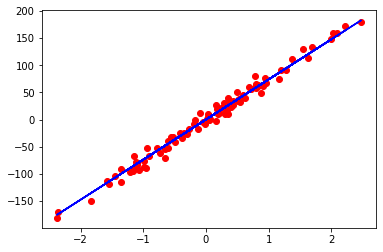

In [6]:
x_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=10, random_state=4)
x = torch.from_numpy(x_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32)).unsqueeze(-1)

model = nn.Linear(x.shape[1], y.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epoch_loop = tqdm(range(0, 2000))
for epoch in epoch_loop:
    y_pred = model(x)
    loss = criterion(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        epoch_loop.set_description(f"epoch: {(epoch + 1):d}")
        epoch_loop.set_postfix_str(f"loss: {loss.item():.4f}")

y_pred = model(x).detach().cpu().numpy()
plt.plot(x_numpy, y_numpy, "ro")
plt.plot(x_numpy, y_pred, "b")
plt.show()

## 5. Logistic Regression

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

bc = datasets.load_breast_cancer()
x, y = bc.data, bc.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train = torch.from_numpy(x_train.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(-1)
y_test = torch.from_numpy(y_test.astype(np.float32)).unsqueeze(-1)

model = nn.Sequential(
    nn.Linear(x_train.shape[1], 1),
    nn.Sigmoid()
)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

epoch_loop = tqdm(range(0, 100))
for epoch in epoch_loop:
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred_cls = y_pred.round()
            acc = y_pred_cls.eq(y_test).sum() / (y_test.shape[0])
        epoch_loop.set_description(f'epoch: {epoch + 1}')
        epoch_loop.set_postfix_str(f'loss = {loss.item():.4f}, acc = {acc:.4f}')

epoch: 100: 100%|██████████| 100/100 [00:00<00:00, 4107.55it/s, loss = 0.2591, acc = 0.9386]


## 6. Dataset & Dataloader

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class LogisticDataset(Dataset):
    def __init__(self, train=True):
        bc = datasets.load_breast_cancer()
        x, y = bc.data, bc.target
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

        sc = StandardScaler()
        x_train = sc.fit_transform(x_train)
        x_test = sc.transform(x_test)

        self.x_train = torch.from_numpy(x_train.astype(np.float32))
        self.x_test = torch.from_numpy(x_test.astype(np.float32))
        self.y_train = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(-1)
        self.y_test = torch.from_numpy(y_test.astype(np.float32)).unsqueeze(-1)
        self.train = train
    
    def __len__(self):
        if self.train:
            return len(self.x_train)
        else:
            return len(self.x_test)
    
    def __getitem__(self, index):
        if self.train:
            return self.x_train[index], self.y_train[index]
        else:
            return self.x_test[index], self.y_test[index]

train_dataset = LogisticDataset(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = LogisticDataset(train=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

model = nn.Sequential(
    nn.Linear(30, 1),
    nn.Sigmoid()
)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion= nn.BCELoss()

epoch_loop = tqdm(range(0, 10), leave=True)
for epoch in epoch_loop:
    num_batches = len(train_dataloader)
    epoch_per_batch = 1.0 / num_batches

    for i, (data, target) in enumerate(train_dataloader):
        epoch += epoch_per_batch
        epoch_loop.set_description(f'epoch: {epoch:.3f}')

        y_pred = model(data)
        loss = criterion(y_pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            epoch_loop.set_postfix_str(f'loss = {loss.item():.4f}')
    if round(epoch) % 10 == 0:
        num_corrects = 0
        num_samples = 0
        for i, (data, target) in enumerate(test_dataloader):
            with torch.no_grad():
                y_pred = model(data)
                y_pred_cls = y_pred.round()
                num_corrects += y_pred_cls.eq(target).sum()
                num_samples += y_pred_cls.shape[0]
            acc = num_corrects / num_samples
            epoch_loop.set_postfix_str(f'loss = {loss.item():.4f}, acc = {acc:.4f}')

epoch: 10.000: 100%|██████████| 10/10 [00:00<00:00, 14.06it/s, loss = 0.0208, acc = 0.9737]


## 7. Softmax & Crossentropy
* PyTorch默认的```nn.CrossEntropyLoss```，等同于```nn.LogSoftmax + nn.NLLLoss```，因此不需要在网络的最后使用```torch.softmax```，并且label的shape是```（n_samples, )```，不是one-hot编码

In [22]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def cross_entropy_loss(x, y):
    return -np.dot(y, np.log(x))

out = np.array([2.0, 1.0, 0.1], dtype=np.float32)
label = np.array([1, 0, 0], dtype=np.float32)
pred = softmax(out)
print(cross_entropy_loss(pred, label))

out = torch.tensor([[2.0, 1.0, 0.1], [1.0, 2.0, 0.1]])  # shape: n_sample * n_cls
label = torch.tensor([0, 1])  # shape: n_sample
criterion = nn.CrossEntropyLoss()
print(criterion(out, label))

0.41703007
torch.Size([2])
tensor(0.4170)


## 8. Tensorboard
* global_step：可以用于显示同一个tag下不同step的图片，随着epoch的增加，显示不同的预测结果
* add_image：tensor或者array，shape：c * h * w

In [16]:
import cv2 as cv
from einops import rearrange
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("./runs")

# matplotlib.pyplot.figure
fig = plt.figure(1)
plt.plot([0, 1, 2], [2, 3, 4], '-')
writer.add_figure("figure", fig)

# image: c * h * w
img = rearrange(cv.imread("./materials/panda.jpg"), 'h w c -> c h w')
img2 = rearrange(cv.imread("./materials/panda2.jpg"), 'h w c -> c h w')
writer.add_image("images", img, global_step=0)
writer.add_image("images", img2, global_step=1)

# model
model = nn.Sequential(
    nn.Linear(10, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
input = torch.rand(4, 10)
writer.add_graph(model, input_to_model=input)

for epoch in range(0, 10):
    writer.add_scalar("loss", 2 * epoch + 1, epoch)

writer.close()

## Distributed Traning
* 采用```DistributedDataParallel```训练时，如果从头训练负载相对均衡，而从checkpoint开始训练就出现负载不均衡，可以采用```state = torch.load('xxx.pth', map=torch.device('cpu'))```解决
* 保存模型时，注意加```if dist.get_rank() == 0```来保证只在一个线程里面保存，不然后面load的时候会出错
* 只需要在一个线程里面执行的操作，比如打印误差，日志等，也可以用```if dist.get_rank() == 0```来实现

In [7]:
import torch
len(torch.__all__)
len(dir(torch))

1034